In [1]:
import sys
sys.path.append('/home/monte.flora/python_packages/scikit-explain/')
sys.path.append('/home/monte.flora/python_packages/master/ml_workflow')
sys.path.append('/work/mflora/ROAD_SURFACE')
import skexplain
from os.path import join
import pickle
import seaborn as sns
import numpy as np
import pandas as pd
from glob import glob
import joblib
import matplotlib.pyplot as plt
from display_names import to_readable_names, get_units, to_color

from probsr_config import PREDICTOR_COLUMNS, FIGURE_MAPPINGS, COLOR_DICT
from skexplain.common.importance_utils import to_skexplain_importance

In [2]:
import xarray as xr
def to_xarray(shap_data, estimator_name, feature_names=None):
    dataset={}
    
    shap_values = shap_data['shap_values']
    bias = shap_data['bias']
    
    dataset[f'shap_values__{estimator_name}'] = (['n_examples', 'n_features'], shap_values)
    dataset[f'bias__{estimator_name}'] = (['n_examples'], bias.astype(np.float64))
    dataset['X'] = (['n_examples', 'n_features'], shap_data['X'])
    dataset['y'] = (['n_examples'], shap_data['targets'])
    
    ds = xr.Dataset(dataset)
    #ds.attrs['features'] = feature_names
    
    return ds 

In [3]:
hazard = 'tornado'

# Load the WoFS data. 
base_path = '/work/mflora/ML_DATA/DATA'
data_path = join(base_path, f'original_first_hour_training_matched_to_{hazard}_0km_data.feather')
df = pd.read_feather(data_path)


# Load the WoFS-ML-Severe Models
base_path = '/work/mflora/ML_DATA/MODEL_SAVES'
model_name = 'LogisticRegression'
model_paths = glob(join(base_path, f'{model_name}_first_hour_{hazard}*'))
model_path = [m for m in model_paths if 'manual' not in m][0]
model_data = joblib.load(model_path)

model = model_data['model']
feature_names = model_data['features']

X = df[feature_names].astype(float)
y = df[f'matched_to_{hazard}_0km'].astype(float)


all_features = df.columns
display_feature_names = {f : to_readable_names(f) for f in all_features}
feature_colors = {f : to_color(f) for f in all_features}

feature_colors = {**feature_colors, **COLOR_DICT}
display_feature_names = {**display_feature_names, **FIGURE_MAPPINGS}

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [4]:
explainer = skexplain.ExplainToolkit(X=X,y=y)

In [5]:
# backward singlepass, forward multipass, coefs/gini, SHAP 
base_path = '/work/mflora/ML_DATA/'

other_base_path = '/work/mflora/explainability_work/results'

def load_imp(hazard):
    if hazard == 'road_surface':
        name = 'Random Forest'
    else:
        name = 'LogisticRegression'
    
    # permutation results
    if hazard == 'road_surface': 
        basePath = '/work/mflora/ROAD_SURFACE'
        bsp_fname = join(basePath,'permutation_importance', f'perm_imp_original_backward.nc')
        fmp_fname = join(basePath,'permutation_importance', f'perm_imp_original_forward.nc')
    else:    
        path = join(base_path, 'permutation_importance')
        bsp_fname = join(path, f'perm_imp_{hazard}_first_hour__backward.nc' )
        fmp_fname = join(path, f'perm_imp_{hazard}_first_hour__forward.nc' ) 
        
        #bsp_fname = join(path, f'permutation_importance_{hazard}_first_hour_training_norm_aupdcbackward.nc' )
        #fmp_fname = join(path, f'permutation_importance_{hazard}_first_hour_training_norm_aupdcforward.nc' )   

    bsp = explainer.load(bsp_fname)
    bmp = bsp.copy()
    fmp = explainer.load(fmp_fname)
    fsp = fmp.copy()
    
    # Backward singlepass and forward multipass: original_score - permuted score
    original_score = bsp[f'original_score__{name}'].values
    scores = original_score - bsp[f'singlepass_scores__{name}'].values
    bsp[f'singlepass_scores__{name}'] = (['n_vars_singlepass', 'n_permute'], scores)
    
    original_score = fmp[f'original_score__{name}'].values
    scores = original_score - fmp[f'multipass_scores__{name}'].values
    fmp[f'multipass_scores__{name}'] = (['n_vars_multipass', 'n_permute'], scores)

    # ALE     
    if hazard == 'road_surface':
        ale_var_fname = join(basePath,'ale_results', 'ale_var_rf_original.nc')
        ale_var = explainer.load(ale_var_fname)
        
    else:
        # ale results
        ale_fname = join(base_path,'ALE_RESULTS', f'ale_var_results_all_models_{hazard}_first_hour.nc')
        ale_var = explainer.load(ale_fname)
    
        
    if hazard == 'road_surface':
        # load the random forest
        rf = joblib.load(join(basePath, 'JTTI_ProbSR_RandomForest.pkl'))
        gini_values = rf.feature_importances_
        gini_rank = to_skexplain_importance(gini_values,
                                       estimator_name='Random Forest', 
                                       feature_names=PREDICTOR_COLUMNS, 
                                         method = 'gini')
        
    else:
        coefs = model.base_estimator.named_steps['model'].coef_[0]
        coef_rank = to_skexplain_importance(coefs,
                                       estimator_name=name, 
                                       feature_names=X.columns, 
                                        method = 'coefs')

    # shap results
    if hazard == 'road_surface':
        fname = join(basePath,'shap_results', 'shap_rf_original.nc')
    else:
        fname = join(base_path, 'SHAP_VALUES', f'shap_values_LogisticRegression_{hazard}_first_hour.pkl')
    
    with open(fname, 'rb') as f:
        shap_data = pickle.load(f)
        shap_vals = shap_data['shap_values']
    
    shap_rank = to_skexplain_importance(shap_vals, 
                                      estimator_name=name, 
                                      feature_names=X.columns, 
                                      method ='shap_sum', )
    
    # Lime results 
    lime_rank = explainer.load(join(other_base_path, f'lime_rank_{hazard}_original.nc'))
    
    if hazard == 'road_surface':
        return ([bsp, bmp, fsp, fmp, gini_rank, shap_rank, ale_var, lime_rank],
                ['singlepass', 'multipass', 'singlepass', 'multipass', 'gini', 'shap_sum', 
                 'ale_variance', 'lime'], name)
                
    else:
        return ([bsp, bmp, fsp, fmp, coef_rank, shap_rank, ale_var, lime_rank],
                ['singlepass', 'multipass', 'singlepass', 'multipass', 'coefs', 'shap_sum', 
                 'ale_variance', 'lime'], name)

In [6]:
results, methods, name = load_imp('tornado')

In [7]:
names = [name]*len(methods)
data=[]
for ds,m, name in zip(results, methods, names):
    imp = ds[f'{m}_scores__{name}'].values
    imp[imp==0] = 0.000001
    imp_norm = imp/ (np.percentile(imp, 99) - np.percentile(imp, 1))
    ds[f'{m}_scores__{name}'] = ([f'n_vars_{m}', 'n_permute'], imp_norm)
    data.append(ds)

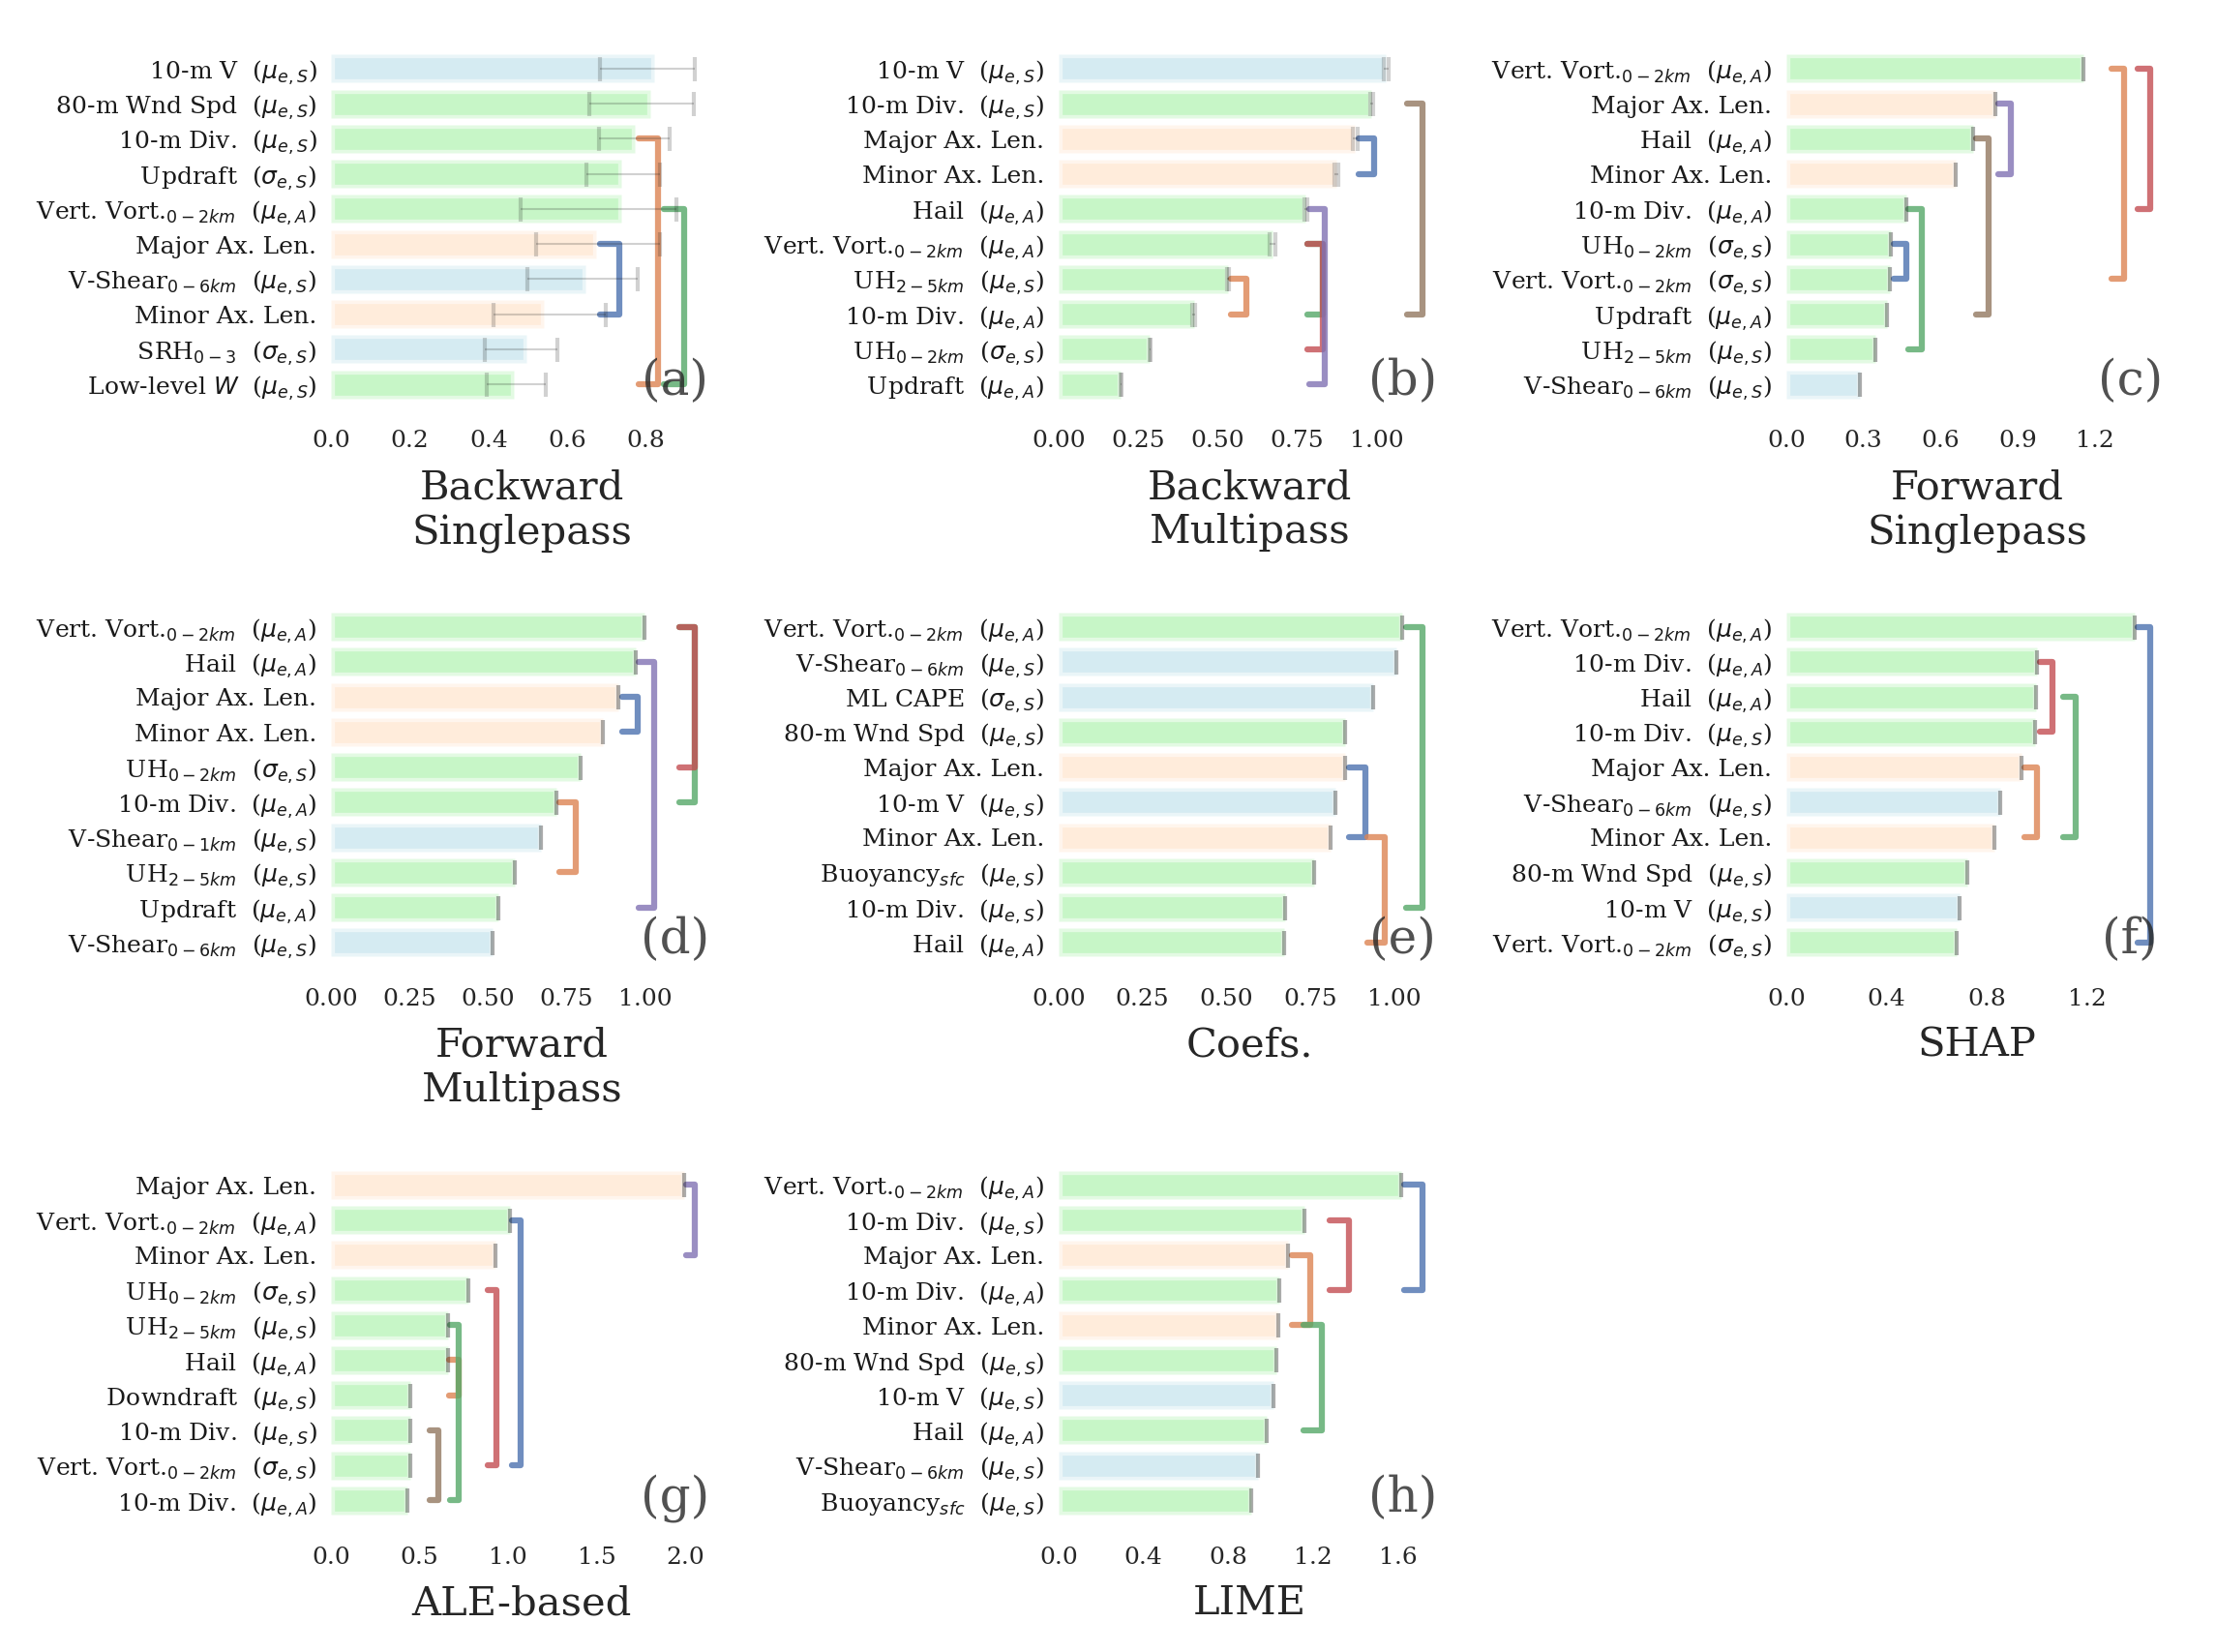

In [8]:
xlabels = ['Backward\nSinglepass', 'Backward\nMultipass', 'Forward\nSinglepass', 'Forward\nMultipass', 
           'Coefs.', 'SHAP', 'ALE-based', 'LIME']


panels = [(m, n) for m, n in zip(methods, names)]
fig = explainer.plot_importance(data=data, panels=panels, 
                                num_vars_to_plot=10, 
                                display_feature_names=display_feature_names,
                                feature_colors=feature_colors,
                                plot_correlated_features=True, 
                                n_columns=3,
                                xlabels=xlabels,
                                figsize=(8, 6), 
                                base_font_size= 12,
                                wspace=1.0, 
                                alphabet_fontsize=12, 
                                rho_threshold=0.6
                               )